In [1]:
import numpy as np
import pandas as pd
from numpy import concatenate
from matplotlib import pyplot
from keras.models import Sequential
from keras.callbacks import Callback
from keras.layers import LSTM, Dense, Activation
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
N_DATA_ORIG = 3000
N_FEATURES = 5
N_ROLLING = 1000
N_TIMESTEPS = 5
N_DATA = N_DATA_ORIG - N_ROLLING
N_TRAIN_ITERATIONS = 5
N_EPOCHS = 5
BATCH_SIZE = 100
N_LAYERS = 3
N_LSTM_UNITS = 2
BREAK_LEN = 1000
random_break_point = np.random.choice(N_DATA)

In [3]:
# make some noisy but smooth looking data
data = np.sqrt(np.random.rand(N_DATA_ORIG,N_FEATURES))
df_data = pd.DataFrame(data)
df_data = df_data.rolling(window=N_ROLLING).mean()
df_data = df_data.dropna()
df_data = df_data.head(N_DATA)
print(df_data.shape)
data = df_data.values

(2000, 5)


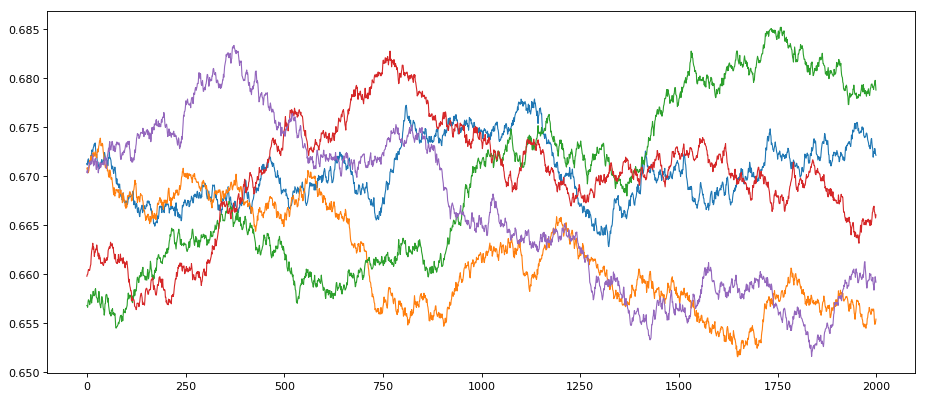

In [4]:
# plot the normal healthy data
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data)
for x in range(data.shape[1]):
    ax.plot(range(0,size), data[:,x], '-', linewidth=1)

In [5]:
# make some random data
data_rand = np.random.rand(N_DATA,N_FEATURES)
data_new = np.copy(data)
# at a random point for a certain number of steps, swap out the smooth data with some random data
data_new[random_break_point:(random_break_point+BREAK_LEN)] = data_rand[random_break_point:(random_break_point+BREAK_LEN)]

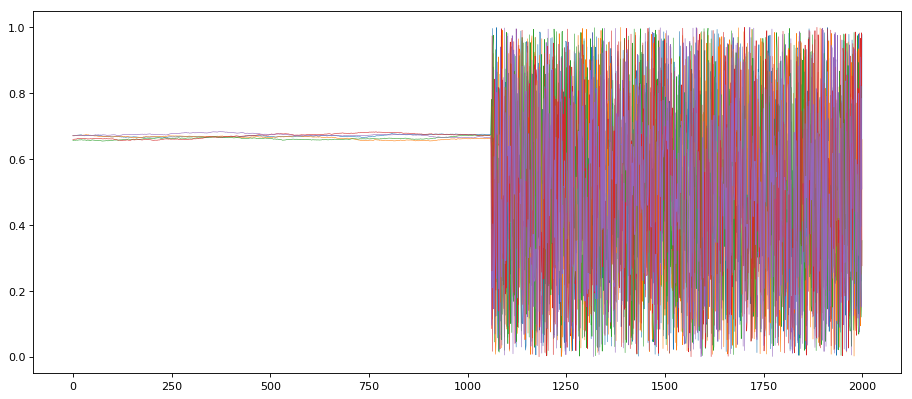

In [6]:
# plot the new data
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_new)
for x in range(data_new.shape[1]):
    ax.plot(range(0,size), data_new[:,x], '-', linewidth=0.5)

In [7]:
# build some helper functions to store losses in for use later

losses = []
 
def handleLoss(loss,print_info=False):
    global losses
    losses+=[loss]
    if print_info: print(loss)
    
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        handleLoss(logs.get('loss'))

In [8]:
def data_reshape_for_model(data_in,n_timesteps,n_features,print_info=True):
    ''' Function to reshape the data into model ready format, either for training or prediction.
    '''
    # get original data shape
    data_in_shape = data_in.shape
    # create a dummy row with desired shape and one empty observation
    data_out = np.zeros((1,n_timesteps,n_features))
    # loop though each row of data and reshape accordingly
    for row in range(len(data_in)):
        # for each row look ahead as many timesteps as needed and then transpose the data to give shape keras wants
        tmp_array = np.array([data_in[row:(row+n_timesteps),].transpose()])
        # if your reshaped data is as expected then concate the new observation into data_out 
        if tmp_array.shape == (1,n_timesteps,n_features):
            data_out = np.concatenate((data_out,tmp_array))
    # drop first dummy row of data_out
    data_out = data_out[1:]
    # get output data shape
    data_out_shape = data_out.shape
    if print_info: print(f'{data_in_shape} -> {data_out_shape}')
    
    return data_out
    

def train(model,data,n_epochs=10,batch_size=50,print_info=False,callbacks=None,shuffle=False,verbose=1):
    ''' Function to take in model and data and train the model using defined params.
    '''
    # fit the model to the data
    model.fit(data, data, epochs=n_epochs, batch_size=batch_size, 
              validation_data=(data, data), verbose=verbose, shuffle=shuffle, 
              callbacks=callbacks)
    
    return model


def predict(model,data,print_info=True):
    ''' Function to take in model and data and return predictions in model data format.
    '''
    # get prediction from model
    yhat =  model.predict(data)
    if print_info: print(yhat.shape)
    
    return yhat


def model_data_to_df_long(data,n_timesteps,n_features):
    ''' Function to take model data numpy array and translate it into a long format dataframe.
    '''
    # define empty list to collect data into
    data_tmp = []
    # for each row in the data
    for r in range(len(data)):
        row = data[r]
        # for each feature in each row
        for f in range(n_features):
            # for each timestep of each feature in each row
            for t in range(n_timesteps):
                # add an element to the list decoding what it represents
                tmp = [r,f'f{f}',f't{t}',row[f,t]] 
                # append that element to the data
                data_tmp.append(tmp)
    # now use the collected data to create a pandas df
    df_long = pd.DataFrame(data_tmp,columns=['row','feature','timestep','value'])
    # add a label col that can be used to go from long format to wide
    df_long['label'] = df_long['feature'] + '_' + df_long['timestep']
    
    return df_long


def model_df_long_to_wide(df_long,key_col='label'):
    ''' Function that can translate a long formant model data df into a wide version of it. 
    '''
    # use pivot to go from long to wide
    df_wide = df_long[['row','label','value']].pivot(index='row',columns=key_col,values='value')
    
    return df_wide


def df_out_add_errors(df_out,n_timesteps,n_features):
    ''' Function to take in a df_out type df and add in error columns
    '''
    # loop through to get errors
    f_cols = [f'f{f}' for f in range(n_features)]
    t_cols = [f't{t}' for t in range(n_timesteps)]
    for f_col in f_cols:
        for t_col in t_cols:
            lag = int(t_col.replace('t','')) + 1 
            df_out[f'{f_col}_{t_col}_error'] = df_out[f_col].shift(lag*-1) - df_out[f'{f_col}_{t_col}_yhat']
            
    # get summary error metrics by timestep across all features
    for t_col in t_cols:
        df_out[f'{t_col}_error_avg'] = df_out[[col for col in df_out.columns if f'{t_col}_error' in col]].mean(axis=1)
        df_out[f'{t_col}_error_med'] = df_out[[col for col in df_out.columns if f'{t_col}_error' in col]].median(axis=1)
        df_out[f'{t_col}_error_min'] = df_out[[col for col in df_out.columns if f'{t_col}_error' in col]].min(axis=1)
        df_out[f'{t_col}_error_max'] = df_out[[col for col in df_out.columns if f'{t_col}_error' in col]].max(axis=1)
        df_out[f'{t_col}_error_rng'] = df_out[[col for col in df_out.columns if f'{t_col}_error' in col]].max(axis=1) - df_out[[col for col in df_out.columns if f'{t_col}_error' in col]].min(axis=1)
    
    return df_out


def yhat_to_df_out(data_train,yhat,n_timesteps,n_features):
    ''' Function to take data train and yhat prediction output array from model and turn it into final form of df_out.
    '''
    
    # helper df's
    df_train_long = model_data_to_df_long(data_train,n_timesteps,n_features)
    df_yhat_long = model_data_to_df_long(yhat,n_timesteps,n_features)
    df_train_wide = model_df_long_to_wide(df_train_long)
    df_yhat_wide = model_df_long_to_wide(df_yhat_long)
    df_yhat_wide.columns = [f'{col}_yhat' for col in df_yhat_wide.columns]
    
    # begin process to collect final data frame

    # make df_out
    train_cols_latest = [col for col in df_train_wide.columns if f't{n_timesteps-1}' in col]
    df_out = df_train_wide[train_cols_latest]
    # clean up col names
    df_out.columns = [col.split('_')[0] for col in df_out.columns]
    # now concat train cols and cols from df_yhat_wide
    df_out = pd.concat([df_out,df_yhat_wide],axis=1)
    
    # add in error cols
    df_out = df_out_add_errors(df_out,n_timesteps,n_features)
    
    return df_out

In [9]:
# build network 
model = Sequential()
# add number of layer specified
for layer in range(N_LAYERS):
    model.add(LSTM(N_LSTM_UNITS,input_shape=(N_TIMESTEPS,N_FEATURES),return_sequences=True))
model.add(Dense(N_FEATURES))
model.compile(loss='mae', optimizer='adam')

# print model summary
print(model.summary())

# reshape data for training
print(f'... reshaping data for training ...')
data_train = data_reshape_for_model(data,N_TIMESTEPS,N_FEATURES)

# begin training iterations
for i in range(N_TRAIN_ITERATIONS):
    print(f'... training iteration {i} ...')
    model = train(model,data_train,callbacks=[LossHistory()])
    
# get predictions on healthy data using final trained model
yhat = predict(model,data_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 2)              64        
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 2)              40        
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 2)              40        
_________________________________________________________________
dense_1 (Dense)              (None, 5, 5)              15        
Total params: 159
Trainable params: 159
Non-trainable params: 0
_________________________________________________________________
None
... reshaping data for training ...
(2000, 5) -> (1996, 5, 5)
... training iteration 0 ...
Train on 1996 samples, validate on 1996 samples
Epoch 1/10
1996/1996 [==============================] - 3s 1ms/step - loss: 0.6442 - val_loss: 0.6163
Epoch 2/10
1996/1996 [========

In [10]:
df_out = yhat_to_df_out(data_train,yhat,N_TIMESTEPS,N_FEATURES)

C:\Users\amaguire\.virtualenvs\ami-sWTBbbw7\lib\site-packages\numpy\lib\function_base.py:3400: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


['t0_error_avg', 't1_error_avg', 't2_error_avg', 't3_error_avg', 't4_error_avg']


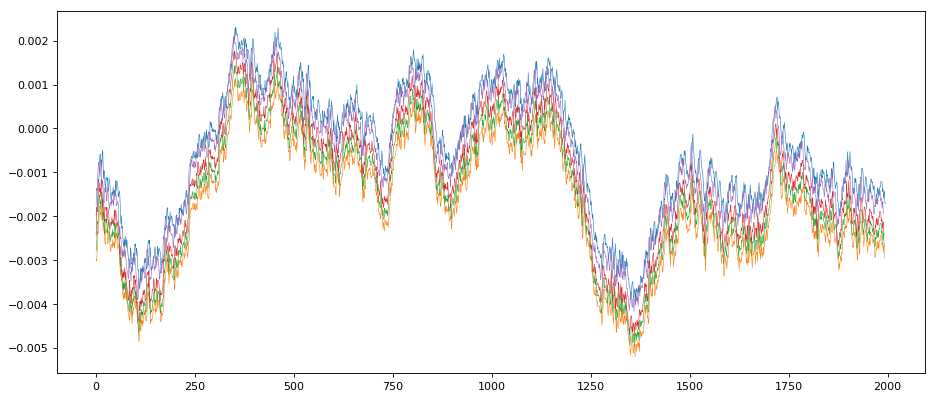

In [11]:
plot_cols = [col for col in df_out.columns if 'error_avg' in col]
print(plot_cols)

# plot the new data
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(df_out)
for col in plot_cols:
    ax.plot(range(0,size), df_out[col], '-', linewidth=0.5)

In [12]:
# now train on new data

print(f'... reshaping data for new data training ...')
data_train_new = data_reshape_for_model(data_new,N_TIMESTEPS,N_FEATURES)

print("... begin training on new data ...")
model = train(model,data_train_new,n_epochs=1)
yhat_new = predict(model,data_train_new)

... reshaping data for new data training ...
(2000, 5) -> (1996, 5, 5)
... begin training on new data ...
Train on 1996 samples, validate on 1996 samples
Epoch 1/1
1996/1996 [==============================] - 0s 175us/step - loss: 0.1293 - val_loss: 0.1400
(1996, 5, 5)


In [13]:
df_out_new = yhat_to_df_out(data_train_new,yhat_new,N_TIMESTEPS,N_FEATURES)

['t0_error_avg', 't1_error_avg', 't2_error_avg', 't3_error_avg', 't4_error_avg']


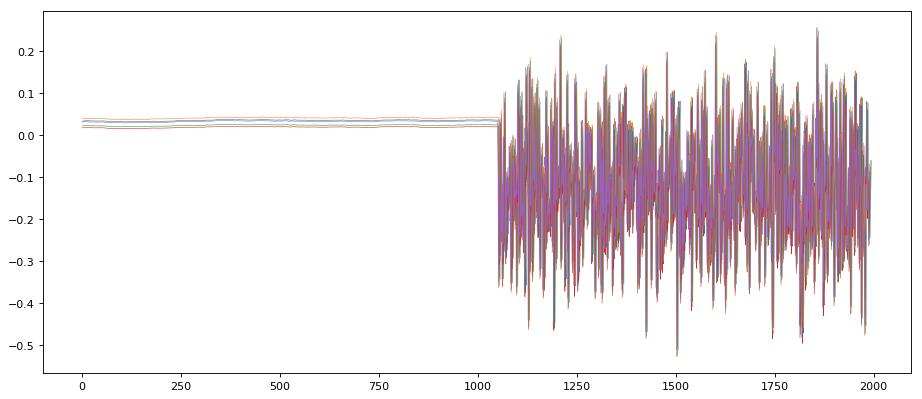

In [14]:
plot_cols = [col for col in df_out_new.columns if 'error_avg' in col]
print(plot_cols)

# plot the new data
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(df_out_new)
for col in plot_cols:
    ax.plot(range(0,size), df_out_new[col], '-', linewidth=0.5)

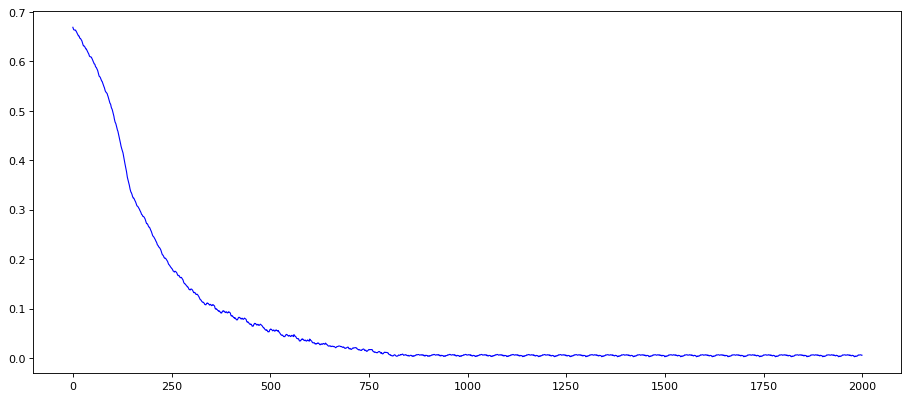

In [15]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(losses)
ax.plot(range(0,len(losses)), losses, '-', color='blue', animated = True, linewidth=1)